In [1]:
from __future__ import division
import csv
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import resample
import mne
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert
#from utils import circular_histogram
#import pycircstat
import os
from datetime import datetime
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#          Joan Massich <mailsik@gmail.com>
#
# License: BSD Style.

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn import preprocessing

# Helpful reading: https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [2]:
file_dir='C:/Users/ASUS/Documents/school/IM680'

In [3]:
patient_id=1351;duration=30;

In [4]:
patient_list=[1351,2510,2939,4301,5852,5995,7257,7838,7844,8898]

In [5]:
patient_id = patient_list[0]

In [6]:
data = pd.read_csv( os.path.join(file_dir, str(patient_id)+'.csv')) 

In [7]:
window = 3

In [9]:
data=data[data['Sleep stage code']!=99]

data.rename(columns={'Unnamed: 0':'SUBJID'},inplace=True)

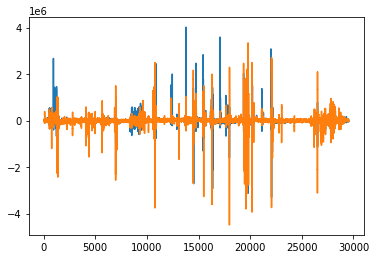

In [10]:
plt.plot(data['time'].values,data['EEG 1E1'].values -np.mean(data['EEG 1E1']))
plt.plot(data['time'].values,data['EEG 1E2'].values-np.mean(data['EEG 1E2']))

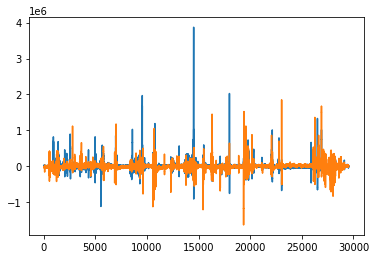

In [11]:
plt.plot(data['time'].values,data['EEG 2E1'].values-np.mean(data['EEG 2E1']))
plt.plot(data['time'].values,data['EEG 2E2'].values-np.mean(data['EEG 2E2']))

In [12]:
np.mean(data['EEG 1E1'])

-15669.003748109682

In [13]:
np.mean(data['EEG 1E2'])

81424.65509149844

In [14]:
np.mean(data['EEG 2E1'])

-35409.55619008838

In [15]:
np.mean(data['EEG 2E2'])

-3667.0866514156955

In [16]:
data['EEG 1E1']=data['EEG 1E1']-np.mean(data['EEG 1E1'])
data['EEG 1E2']=data['EEG 1E2']-np.mean(data['EEG 1E2'])
data['EEG 2E1']=data['EEG 2E1']-np.mean(data['EEG 2E1'])
data['EEG 2E2']=data['EEG 2E2']-np.mean(data['EEG 2E2'])

In [17]:
data=data.rolling(window=3).median()

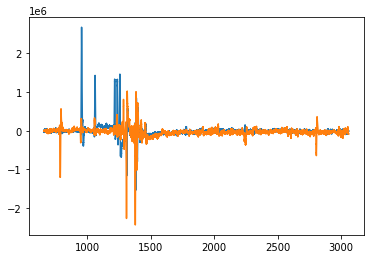

In [18]:
plt.plot(data['time'].values[3000*20:3000*100],data['EEG 1E1'].values[3000*20:3000*100])
plt.plot(data['time'].values[3000*20:3000*100],data['EEG 1E2'].values[3000*20:3000*100])

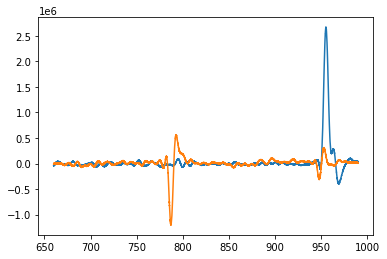

In [19]:
plt.plot(data['time'].values[3000*20:3000*31],data['EEG 1E1'].values[3000*20:3000*31])
plt.plot(data['time'].values[3000*20:3000*31],data['EEG 1E2'].values[3000*20:3000*31])
#plt.plot(data['time'].values,data['EEG 2E1'].values)
#plt.plot(data['time'].values,data['EEG 2E2'].values)

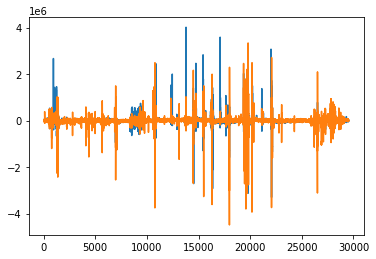

In [20]:
plt.plot(data['time'].values,data['EEG 1E1'].values)
plt.plot(data['time'].values,data['EEG 1E2'].values)

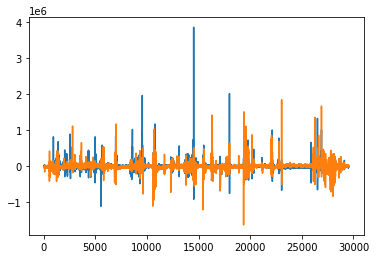

In [21]:
plt.plot(data['time'].values,data['EEG 2E1'].values)
plt.plot(data['time'].values,data['EEG 2E2'].values)

In [22]:
def data_reform(patient_id,duration): 
    data = pd.read_csv( os.path.join(file_dir, str(patient_id)+'.csv')) 

    data=data[data['Sleep stage code']!=99]

    data.rename(columns={'Unnamed: 0':'SUBJID'},inplace=True)

    data['SUBJID']=patient_id
    data['EEG 1E1']=data['EEG 1E1']-np.mean(data['EEG 1E1'])
    data['EEG 1E2']=data['EEG 1E2']-np.mean(data['EEG 1E2'])
    data['EEG 2E1']=data['EEG 2E1']-np.mean(data['EEG 2E1'])
    data['EEG 2E2']=data['EEG 2E2']-np.mean(data['EEG 2E2'])
    #window= 15;threshold =200000;
    data=data.rolling(window=3).median()
    

    

    #data['Sleep stage code'].values
    
    sample1=data.iloc[:,3:-1]

    x = sample1.values #returns a numpy array
    #min_max_scaler = preprocessing.MinMaxScaler(feature_range= (-1,1))
    #x_scaled = min_max_scaler.fit_transform(x)
    #df = pd.DataFrame(x_scaled)

    #int(len(sample1)/duration)

    reformed_xdata=[]
    reformed_ydata=[]
    duration=duration*100;
    for i in range(1, int(len(sample1)/duration)):
        reformed_xdata.append(x[duration*i:duration*(i+1)])
        reformed_ydata.append(data['Sleep stage code'].values[i*duration])
    
    return reformed_xdata,reformed_ydata

In [23]:
duration = 30 

In [24]:
reformed_xdata=[]
reformed_ydata=[]
patient_length=[]
for patient_id in patient_list:
    duration = 30 
    xdata,ydata = data_reform(patient_id,duration)
    index=[]
    for i in range(len(xdata)):
        if np.max(xdata[i][:,-4:]) <= 200000 and np.min(xdata[i][:,-4:]) >= -200000:
            index.append(i)
    print(len(index))
    x_result= [xdata[i] for i in index]
    y_result = [ydata[i] for i in index]
    reformed_xdata+=x_result
    reformed_ydata+=y_result
    patient_length.append(len(y_result))

697
683
760
641
658
804
549
570
418
471


In [25]:
reformed_xdata = np.asarray(reformed_xdata)

In [26]:
reformed_ydata = np.asarray(reformed_ydata)

In [27]:
reformed_xdata.shape

(6251, 3000, 15)

In [28]:
def plot_eeg_data(reformed_xdata,loc):
    plt.plot(reformed_xdata[loc,:,-1],label='EEG 2E2')
    plt.plot(reformed_xdata[loc,:,-2],label='EEG 2E1')
    plt.plot(reformed_xdata[loc,:,-3],label='EEG 1E2')
    plt.plot(reformed_xdata[loc,:,-4],label='EEG 1E1')
    plt.legend(loc=4)

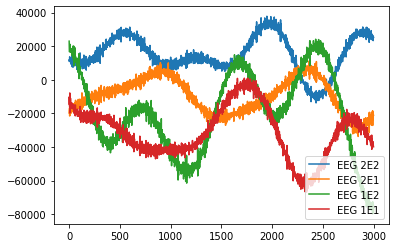

In [29]:
plot_eeg_data(reformed_xdata,100)   

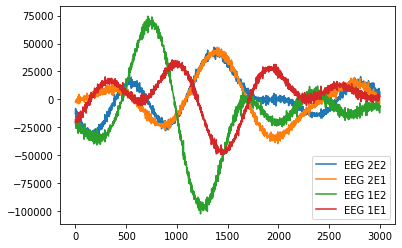

In [30]:
plot_eeg_data(reformed_xdata,500)

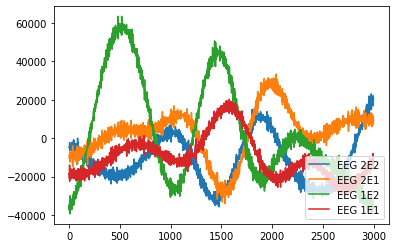

In [31]:
plot_eeg_data(reformed_xdata,1701)

we drop all samples that have over 200000 microV measurement and over 5s of flat regions

In [32]:
import scipy.io as sio
filepath = 'C:/Users/ASUS/Documents/school/IM680/CRNNeeg-sleep-master/data/data.mat'
mat_file = sio.loadmat(filepath)
n_examples = np.shape(mat_file['sig1'])[0]
x = np.zeros((4, n_examples, 3000, 1))
x[0] = mat_file['sig1']
x[1] = mat_file['sig2']
x[2] = mat_file['sig3']
x[3] = mat_file['sig4']

In [33]:
def eeg_data_2(x, loc):
    plt.plot(x[0,loc,:],label='F3 - C3')
    plt.plot(x[1,loc,:],label='C3 - O1')
    plt.plot(x[2,loc,:],label='F4 - C4')
    plt.plot(x[3,loc,:],label='C3 - O2')
    plt.legend(loc=4)

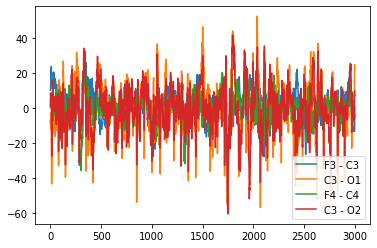

In [34]:
eeg_data_2(x, 110)

In [35]:
np.save(r'C:\Users\ASUS\Documents\school\IM680\SleepySignals_X.npy',reformed_xdata)

In [36]:
np.save(r'C:\Users\ASUS\Documents\school\IM680\SleepySignals_y.npy',reformed_ydata)

In [37]:
patient_length

[697, 683, 760, 641, 658, 804, 549, 570, 418, 471]